## Initialization

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import pandas as pd
import tensorflow as tf
import keras
from sklearn import metrics


from tensorflow.keras import layers
from keras.models import Model
from keras.layers import Dense
from keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from keras.losses import MeanSquaredError
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras.utils import plot_model
from sklearn.model_selection import train_test_split

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.applications.efficientnet_v2 import EfficientNetV2B0
from keras.layers import Input, BatchNormalization, Dropout
from IPython.display import display

import pickle as pkl
import warnings

In [2]:
# Mount to Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Read our structured and image data
df = pd.read_csv('/content/drive/MyDrive/Capstone/pokemon_data.csv')
images_df = pd.read_csv('/content/drive/MyDrive/Capstone/pokemon_images.csv')

In [4]:
df.head()

,id,name,hp,convertedRetreatCost,number,nationalPokedexNumbers,has_rule,has_ability,has_ancient_trait,is_regulation,...,Fire,Grass,Lightning,Metal,Psychic,Water,set_age,is_promo,rarity_score,marketPrice
0,hgss4-1,Aggron,0.368421,0.8,0.0,0.298537,0,0,0,0,...,0,0,0,1,0,0,0.557651,0,0.500000,3.21
1,xy5-1,Weedle,0.131579,0.2,0.0,0.012683,0,0,0,0,...,0,1,0,0,0,0,0.398381,0,0.166667,0.12
2,pl1-1,Ampharos,0.342105,0.4,0.0,0.176585,0,1,0,0,...,0,0,1,0,0,0,0.622220,0,0.500000,14.81
3,dp3-1,Ampharos,0.342105,0.6,0.0,0.176585,0,1,0,0,...,0,0,1,0,0,0,0.670186,0,0.500000,19.65
4,det1-1,Bulbasaur,0.157895,0.2,0.0,0.000976,0,0,0,0,...,0,1,0,0,0,0,0.242493,0,0.166667,0.60


In [5]:
# Add the market price to the images
images_df = images_df.merge(df[['id', 'marketPrice']], on='id', how='inner')

images_df.head()


,id,name,image_url,image_path,marketPrice
0,hgss4-1,Aggron,https://images.pokemontcg.io/hgss4/1.png,/content/drive/MyDrive/Capstone/pokemon_images...,3.21
1,xy5-1,Weedle,https://images.pokemontcg.io/xy5/1.png,/content/drive/MyDrive/Capstone/pokemon_images...,0.12
2,pl1-1,Ampharos,https://images.pokemontcg.io/pl1/1.png,/content/drive/MyDrive/Capstone/pokemon_images...,14.81
3,dp3-1,Ampharos,https://images.pokemontcg.io/dp3/1.png,/content/drive/MyDrive/Capstone/pokemon_images...,19.65
4,det1-1,Bulbasaur,https://images.pokemontcg.io/det1/1.png,/content/drive/MyDrive/Capstone/pokemon_images...,0.60


In [6]:
# Perform a log transform on the market price
images_df['marketPrice'] = np.log(images_df['marketPrice'])
df['marketPrice'] = np.log(df['marketPrice'])

In [7]:
# Remove newest sets for testing in image data
test_im_df = images_df[images_df['id'].str.startswith('me1-')]
images_df = images_df[~images_df['id'].str.startswith('me1-')]

# Remove newest sets for testing in structured data
test_df = df[df['id'].str.startswith('me1-')]
df = df[~df['id'].str.startswith('me1-')]

# Split the indexes
train_idx, val_idx = train_test_split(df.index, test_size=0.2, random_state=42)

# Use the same indexes to split the datasets
train_image = images_df.loc[train_idx]
val_image   = images_df.loc[val_idx]

X_train = df.drop(columns=['id','name', 'marketPrice']).loc[train_idx]
y_train = df['marketPrice'].loc[train_idx]

X_val = df.drop(columns=['id','name', 'marketPrice']).loc[val_idx]
y_val = df['marketPrice'].loc[val_idx]

In [8]:
X_train.head()

,hp,convertedRetreatCost,number,nationalPokedexNumbers,has_rule,has_ability,has_ancient_trait,is_regulation,weakness_count,resistances_count,...,Fighting,Fire,Grass,Lightning,Metal,Psychic,Water,set_age,is_promo,rarity_score
13381,0.157895,0.4,0.375817,0.133659,0,0,0,1,1,0,...,0,0,0,0,0,0,0,0.159988,0,0.166667
285,0.184211,0.2,0.009804,0.307317,0,0,0,0,1,0,...,0,0,1,0,0,0,0,0.286256,0,0.166667
7517,0.131579,0.2,0.222222,0.172683,0,0,0,0,1,0,...,0,0,0,0,0,1,0,0.824434,0,0.166667
9870,0.210526,0.4,0.323529,0.831220,0,0,0,1,1,0,...,1,0,0,0,0,0,0,0.182228,0,0.166667
18846,0.184211,0.2,0.673203,0.364878,0,0,0,1,1,1,...,0,0,0,0,1,0,0,0.108640,1,0.583333


In [9]:
train_image.head()

,id,name,image_url,image_path,marketPrice
13381,swsh6-116,Porygon,https://images.pokemontcg.io/swsh6/116.png,/content/drive/MyDrive/Capstone/pokemon_images...,-2.659260
285,sm5-4,Roselia,https://images.pokemontcg.io/sm5/4.png,/content/drive/MyDrive/Capstone/pokemon_images...,-1.771957
7517,ex2-69,Natu,https://images.pokemontcg.io/ex2/69.png,/content/drive/MyDrive/Capstone/pokemon_images...,-0.755023
9870,swsh4-100,Clobbopus,https://images.pokemontcg.io/swsh4/100.png,/content/drive/MyDrive/Capstone/pokemon_images...,-2.995732
18846,svp-207,Steven's Beldum,https://images.pokemontcg.io/svp/207.png,/content/drive/MyDrive/Capstone/pokemon_images...,2.821974


Our rows stayed aligned, which is expected, but good to see it worked!

##Image CNN

In [10]:
# Update the path to speed up performance for files
!rsync -av /content/drive/MyDrive/Capstone/pokemon_images_dataset/ /content/images/


Streaming output truncated to the last 5000 lines.
swsh10tg-TG19.jpg
swsh10tg-TG20.jpg
swsh10tg-TG21.jpg
swsh10tg-TG22.jpg
swsh10tg-TG23.jpg
swsh10tg-TG24.jpg
swsh10tg-TG25.jpg
swsh10tg-TG26.jpg
swsh10tg-TG27.jpg
swsh10tg-TG28.jpg
swsh10tg-TG29.jpg
swsh10tg-TG30.jpg
swsh11-1.jpg
swsh11-10.jpg
swsh11-100.jpg
swsh11-101.jpg
swsh11-102.jpg
swsh11-103.jpg
swsh11-104.jpg
swsh11-105.jpg
swsh11-106.jpg
swsh11-107.jpg
swsh11-108.jpg
swsh11-109.jpg
swsh11-11.jpg
swsh11-110.jpg
swsh11-111.jpg
swsh11-112.jpg
swsh11-113.jpg
swsh11-114.jpg
swsh11-115.jpg
swsh11-116.jpg
swsh11-117.jpg
swsh11-118.jpg
swsh11-119.jpg
swsh11-12.jpg
swsh11-120.jpg
swsh11-121.jpg
swsh11-122.jpg
swsh11-123.jpg
swsh11-124.jpg
swsh11-125.jpg
swsh11-126.jpg
swsh11-127.jpg
swsh11-128.jpg
swsh11-129.jpg
swsh11-13.jpg
swsh11-130.jpg
swsh11-131.jpg
swsh11-132.jpg
swsh11-133.jpg
swsh11-134.jpg
swsh11-135.jpg
swsh11-136.jpg
swsh11-137.jpg
swsh11-138.jpg
swsh11-139.jpg
swsh11-14.jpg
swsh11-140.jpg
swsh11-141.jpg
swsh11-142.jpg
swsh1

In [11]:
# Update image paths
train_image['image_path'] = train_image['image_path'].str.replace(
    '/content/drive/MyDrive/Capstone/pokemon_images_dataset/',
    '/content/images/',
    regex=False
)

val_image['image_path'] = val_image['image_path'].str.replace(
    '/content/drive/MyDrive/Capstone/pokemon_images_dataset/',
    '/content/images/',
    regex=False
)

test_im_df['image_path'] = test_im_df['image_path'].str.replace(
    '/content/drive/MyDrive/Capstone/pokemon_images_dataset/',
    '/content/images/',
    regex=False
)

In [12]:
# Size to reshape images to
img_size_shape = 224

# Rescale the pixel data
image_train_generator = ImageDataGenerator(rescale=1./255)
image_test_generator = ImageDataGenerator(rescale=1./255)

# Specify the batch pulls for the train generator
image_train_generator = image_train_generator.flow_from_dataframe(
    dataframe=train_image,
    x_col='image_path',
    y_col='marketPrice',
    target_size=(img_size_shape, img_size_shape),
    batch_size=32,
    class_mode='raw'
)

# Specify the batch pulls for the test generator
image_test_generator = image_test_generator.flow_from_dataframe(
    dataframe=val_image,
    x_col='image_path',
    y_col='marketPrice',
    target_size=(img_size_shape, img_size_shape),
    batch_size=32,
    class_mode='raw'
)



Found 15353 validated image filenames.
Found 3839 validated image filenames.


In [ ]:
# img_size_shape = 224

# def load_image(path, label):
#     img = tf.io.read_file(path)
#     img = tf.image.decode_jpeg(img, channels=3)
#     img = tf.image.resize(img, [img_size_shape, img_size_shape])
#     img = img / 255.0
#     return img, label

# train_ds = (
#     tf.data.Dataset.from_tensor_slices(
#         (train_image['image_path'].values,
#          train_image['marketPrice'].values)
#     )
#     .map(load_image, num_parallel_calls=tf.data.AUTOTUNE)
#     .batch(64)
#     .prefetch(tf.data.AUTOTUNE)
# )

# val_ds = (
#     tf.data.Dataset.from_tensor_slices(
#         (val_image['image_path'].values,
#          val_image['marketPrice'].values)
#     )
#     .map(load_image, num_parallel_calls=tf.data.AUTOTUNE)
#     .batch(64)
#     .prefetch(tf.data.AUTOTUNE)
# )


In [ ]:
# Initialize the model
model = EfficientNetV2B0(weights="imagenet", include_top=False, input_tensor=Input(shape=(img_size_shape, img_size_shape, 3)))

# # Freeze the weights to prevent overfitting
# for layer in model.layers:
#   layer.trainable=False

# Create the cnn's configurations
img_input = Input(shape=(img_size_shape, img_size_shape, 3))
x = model(img_input, training=True)
x = layers.GlobalAveragePooling2D()(x)
x = BatchNormalization(name='batch_norm_image')(x)
x = Dense(256, activation='relu', kernel_initializer='he_normal', name='first_dense_hidden_image')(x)
x = Dropout(0.3)(x)
output_cnn = Dense(128, activation='relu', kernel_initializer='he_normal', name='second_dense_hidden_image')(x)
last_layer = Dense(1, activation='linear')(output_cnn)

model = Model(inputs=img_input, outputs=last_layer)

batch_size = 64
epochs = 100
init_learning_rate = 1e-5

# Compile the model w/ Adam as our optimizer, we will look at MSE
model.compile(
    optimizer=Adam(learning_rate=init_learning_rate),
    loss='mse',
    metrics=['mse']
)

model.summary()


24274472/24274472 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetv2-b0 (Functional)  │ (None, 7, 7, 1280)     │     5,919,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_norm_image                │ (None, 1280)           │         5,120 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ first_dense_hidden_image        │ (None, 256)            │       327,936 │
│ (Dense)                         │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ second_dense_hidden_image       │ (None, 128)            │        32,896 │
│ (Dense)                         │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,285,393 (23.98 MB)

 Trainable params: 6,222,225 (23.74 MB)

 Non-trainable params: 63,168 (246.75 KB)

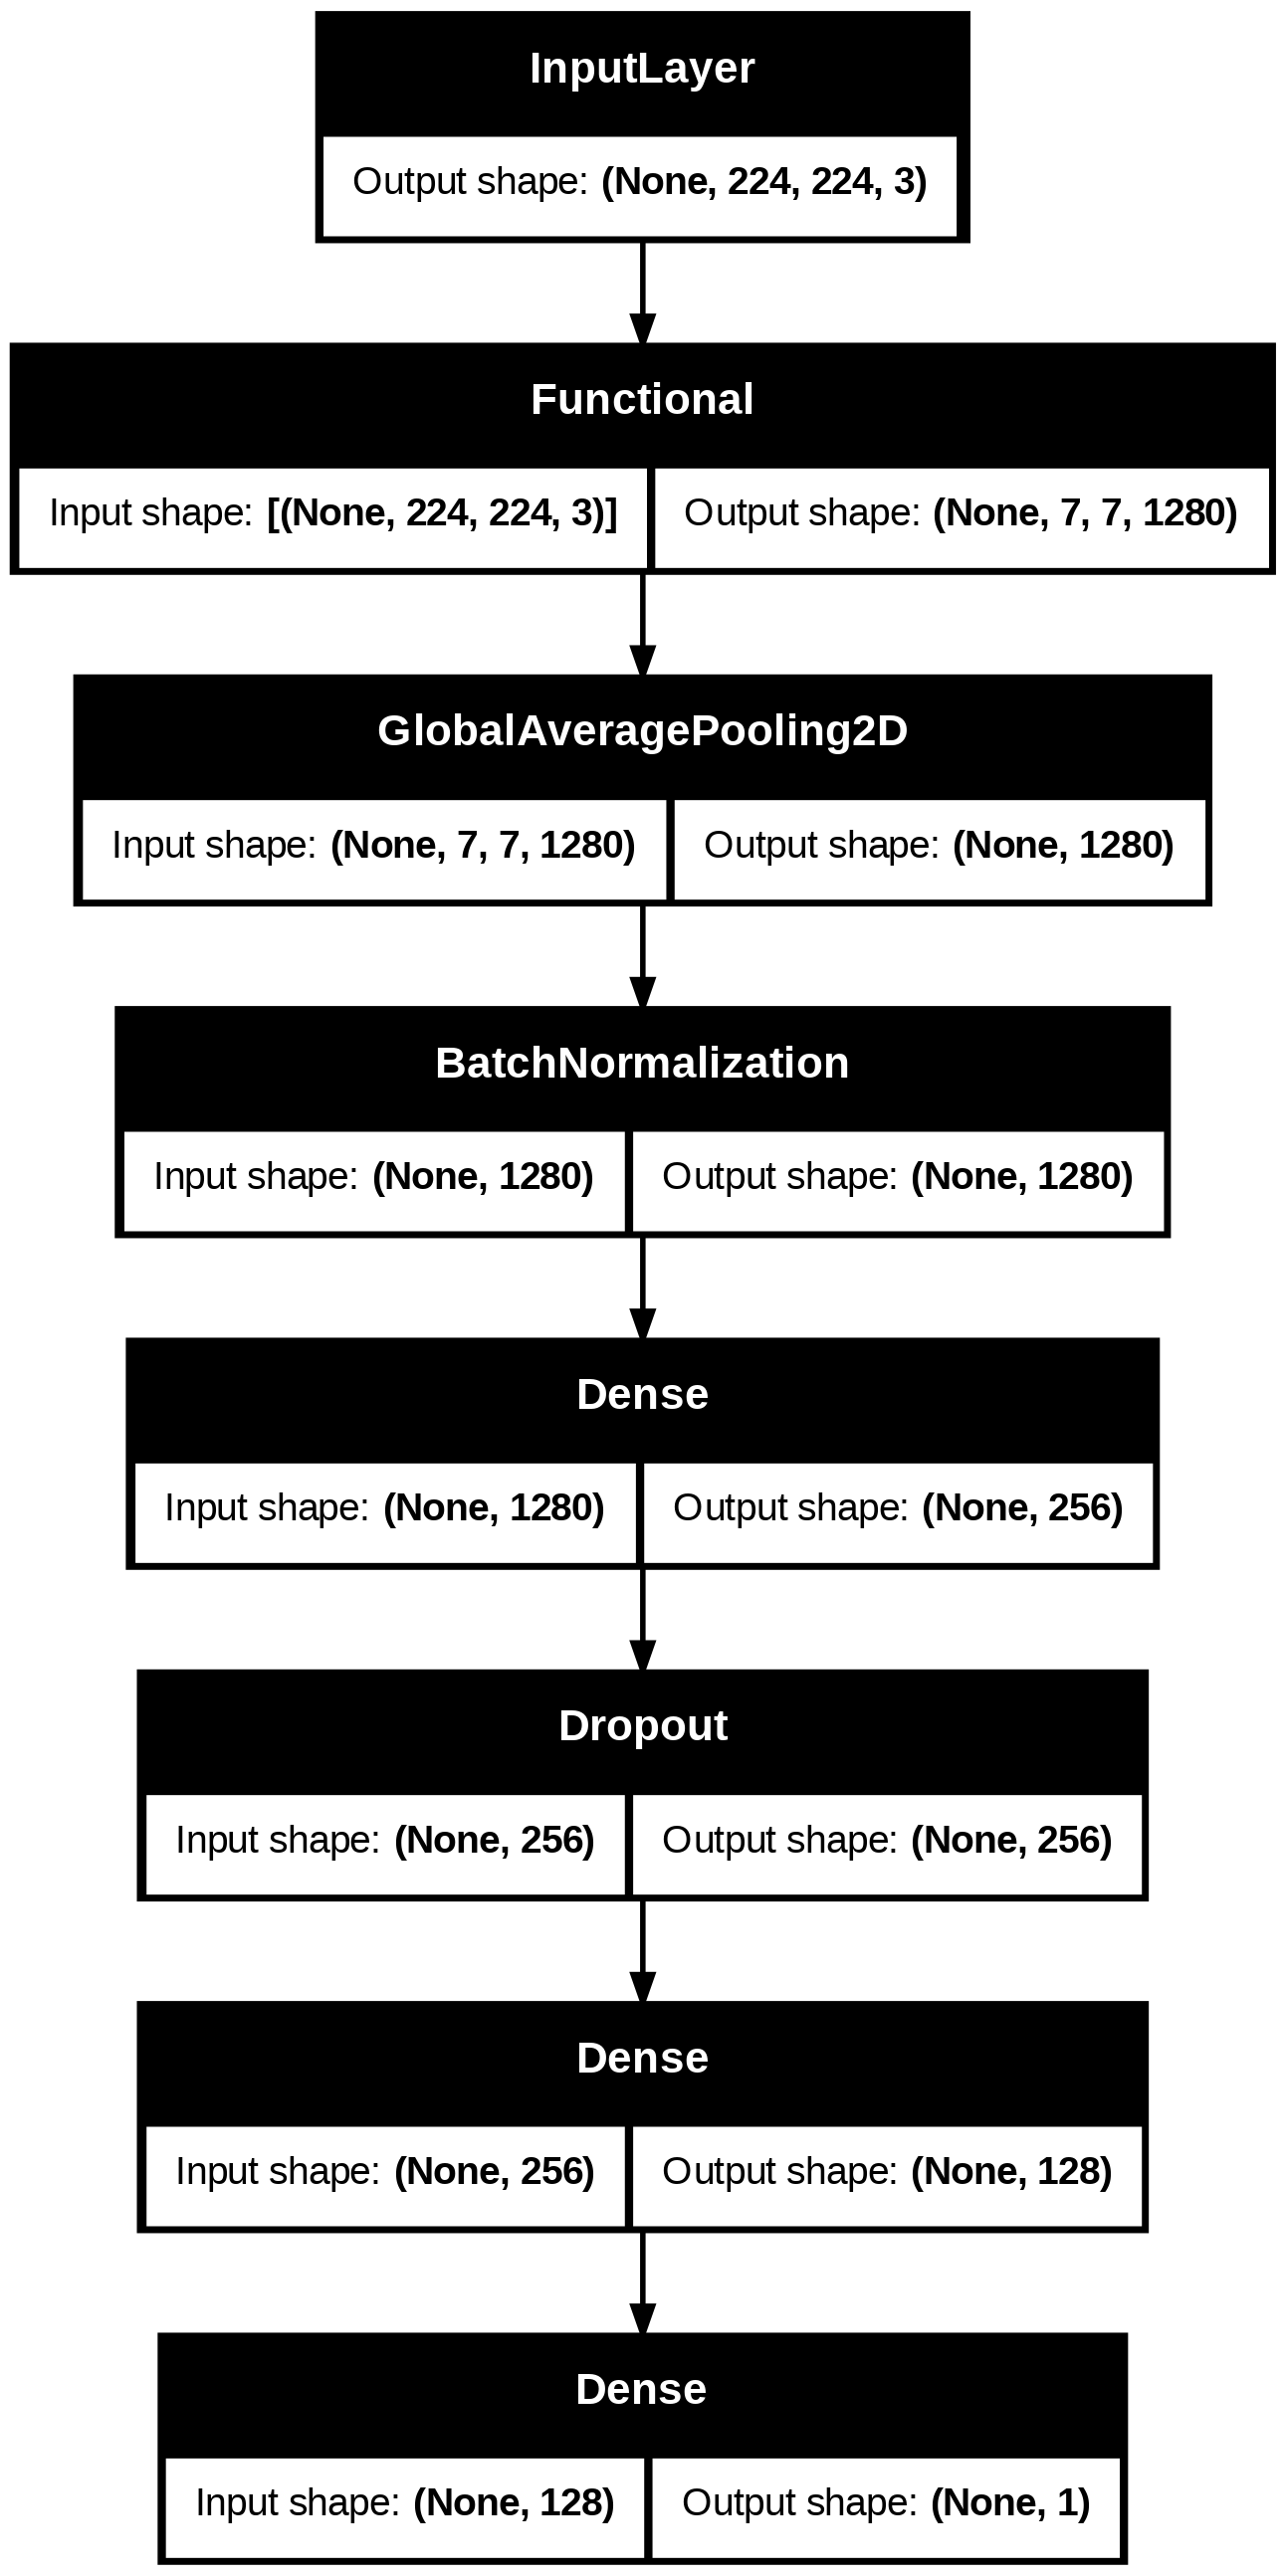

In [ ]:
plot_model(model, show_shapes=True, to_file='EfficientNetV2B0_image.png')

In [ ]:
# Add early stopping
stop = EarlyStopping(monitor='val_loss', patience=30, verbose=1, mode='min', restore_best_weights=True)

# Create checkpoints for best model
best = ModelCheckpoint(filepath='/content/drive/MyDrive/Capstone/best_model_image_checkpoint_v2.keras', monitor='val_loss', verbose=1, save_best_only=True, mode='min')

In [ ]:
# Fit the model
history = model.fit(
    image_train_generator,
    validation_data = image_test_generator,
    verbose=1,
    batch_size=batch_size,
    epochs=epochs,
    callbacks=[stop, best]
)

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/100
480/480 ━━━━━━━━━━━━━━━━━━━━ 0s 387ms/step - loss: 5.2058 - mse: 5.2058
Epoch 1: val_loss improved from inf to 2.70270, saving model to /content/drive/MyDrive/Capstone/best_model_image_checkpoint_v2.keras
480/480 ━━━━━━━━━━━━━━━━━━━━ 339s 492ms/step - loss: 5.2041 - mse: 5.2041 - val_loss: 2.7027 - val_mse: 2.7027
Epoch 2/100
480/480 ━━━━━━━━━━━━━━━━━━━━ 0s 248ms/step - loss: 3.2295 - mse: 3.2295
Epoch 2: val_loss improved from 2.70270 to 2.25761, saving model to /content/drive/MyDrive/Capstone/best_model_image_checkpoint_v2.keras
480/480 ━━━━━━━━━━━━━━━━━━━━ 150s 313ms/step - loss: 3.2293 - mse: 3.2293 - val_loss: 2.2576 - val_mse: 2.2576
Epoch 3/100
480/480 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step - loss: 2.7781 - mse: 2.7781
Epoch 3: val_loss improved from 2.25761 to 2.05596, saving model to /content/drive/MyDrive/Capstone/best_model_image_checkpoint_v2.keras
480/480 ━━━━━━━━━━━━━━━━━━━━ 134s 280ms/step - loss: 2.7781 - mse: 2.7781 - val_loss: 2.0560 - val_mse: 2.0560
Epoch 4/

In [ ]:
# Save the model
model.save('/content/drive/MyDrive/Capstone/best_efficientnet_image_model_v2.keras')

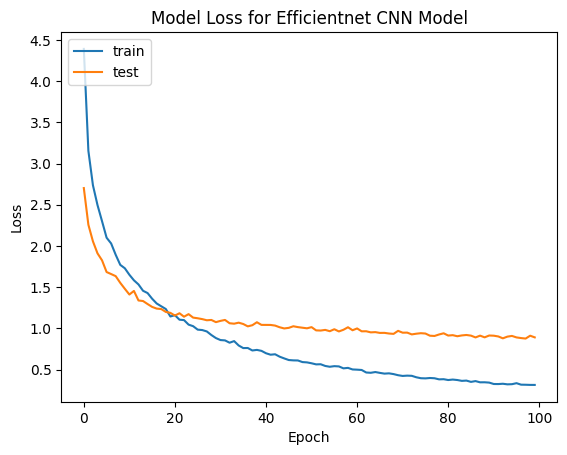

In [ ]:
# Plot the loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss for Efficientnet CNN Model')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

##Tabular ANN (using MLP arcitecture)

In [ ]:
# Build Model arcitecture
structured_input = layers.Input(shape=(X_train.shape[1],), name='structured_input')

x = layers.Dense(64, activation='relu', kernel_initializer='he_normal')(structured_input)
x = BatchNormalization(name='batch_norm_struct_1')(x)
x = Dense(32, activation = 'relu', name = 'first_dense_hidden_struct')(x)
x = BatchNormalization(name='batch_norm_struct_2')(x)
dense_hidden = Dense(16, activation = 'relu', name = 'second_dense_hidden_struct')(x)
last_layer = Dense(1, activation='linear')(dense_hidden)

# Declare inputs and outputs
structured_model = Model(inputs=structured_input, outputs=last_layer)

# Print the final summary
print(structured_model.summary())

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ structured_input (InputLayer)   │ (None, 25)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         1,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_norm_struct_1             │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ first_dense_hidden_struct       │ (None, 32)             │         2,080 │
│ (Dense)                         │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_norm_struct_2             │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ second_dense_hidden_struct      │ (None, 16)             │           528 │
│ (Dense)                         │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,673 (18.25 KB)

 Trainable params: 4,481 (17.50 KB)

 Non-trainable params: 192 (768.00 B)

None


In [ ]:
# Set up learning rate and decay
init_learning_rate = 1e-3
lr_decay = ExponentialDecay(init_learning_rate, decay_steps=1000, decay_rate=0.96, staircase=True)

# Set up early stopping and saving best model checkpoints
stop = EarlyStopping(monitor='val_loss', patience=45, verbose=1, mode='min', restore_best_weights=True)
best = ModelCheckpoint(filepath='/content/drive/MyDrive/Capstone/best_structured_model_checkpoint_v2.keras', monitor='val_loss', verbose=1, save_best_only=True, mode='min')

# Compile the model
structured_model.compile(
    optimizer=Adam(learning_rate=lr_decay),
    loss='mse',
    metrics=['mse']
)

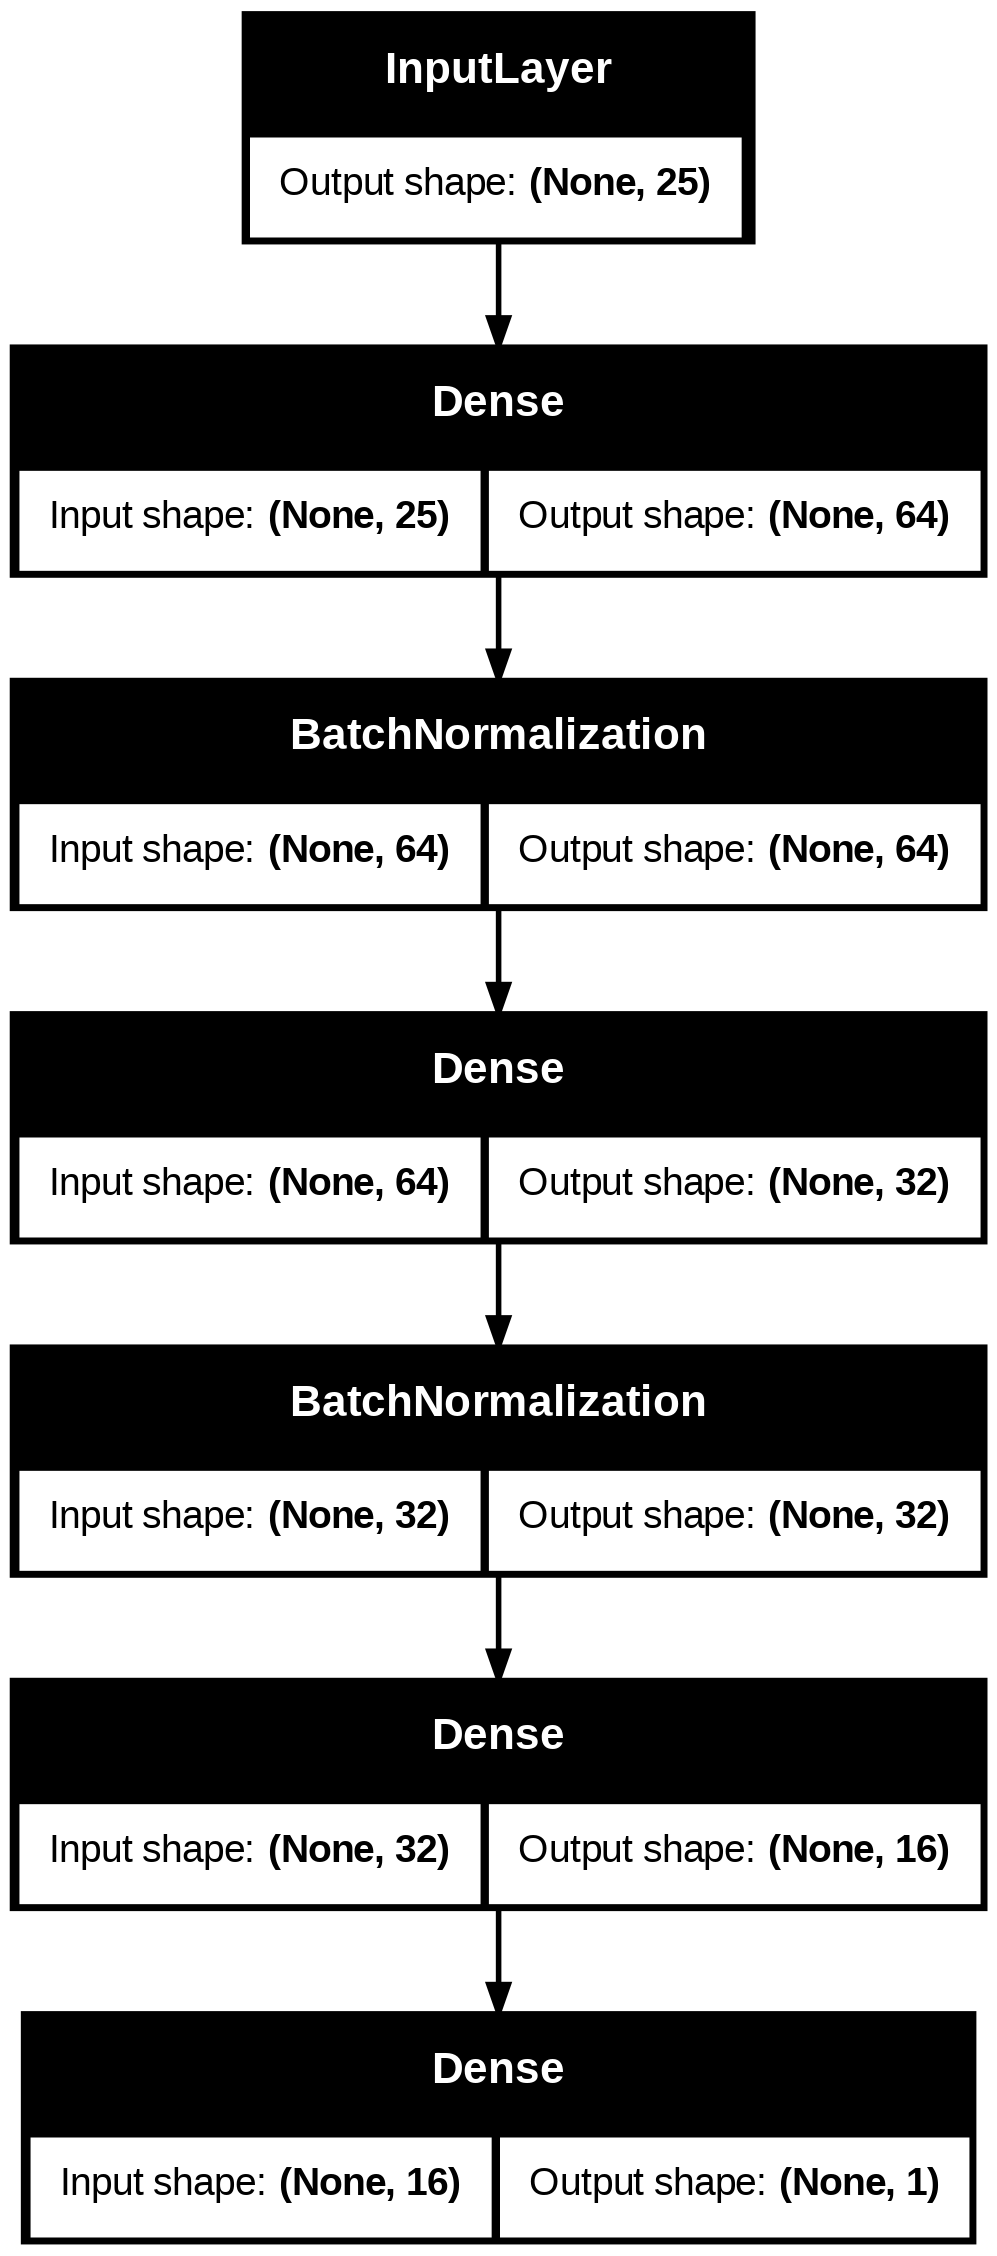

In [ ]:
# Plot the model
plot_model(structured_model, show_shapes=True, to_file='structured_model.png')

In [ ]:
# Fit the model
results = structured_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    verbose=1,
    epochs=500,
    callbacks=[stop, best]
)

Epoch 1/500
480/480 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 3.2846 - mse: 3.2846
Epoch 1: val_loss improved from inf to 1.34224, saving model to /content/drive/MyDrive/Capstone/best_structured_model_checkpoint_v2.keras
480/480 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - loss: 3.2824 - mse: 3.2824 - val_loss: 1.3422 - val_mse: 1.3422
Epoch 2/500
477/480 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.3759 - mse: 1.3759
Epoch 2: val_loss improved from 1.34224 to 1.16102, saving model to /content/drive/MyDrive/Capstone/best_structured_model_checkpoint_v2.keras
480/480 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - loss: 1.3757 - mse: 1.3757 - val_loss: 1.1610 - val_mse: 1.1610
Epoch 3/500
465/480 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.2701 - mse: 1.2701
Epoch 3: val_loss improved from 1.16102 to 1.12031, saving model to /content/drive/MyDrive/Capstone/best_structured_model_checkpoint_v2.keras
480/480 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 1.2698 - mse: 1.2698 - val_loss: 1.1203 - val_mse: 1.1203
Epoch 4/50

In [ ]:
# Save the model
structured_model.save('/content/drive/MyDrive/Capstone/best_structured_model_v2.keras')

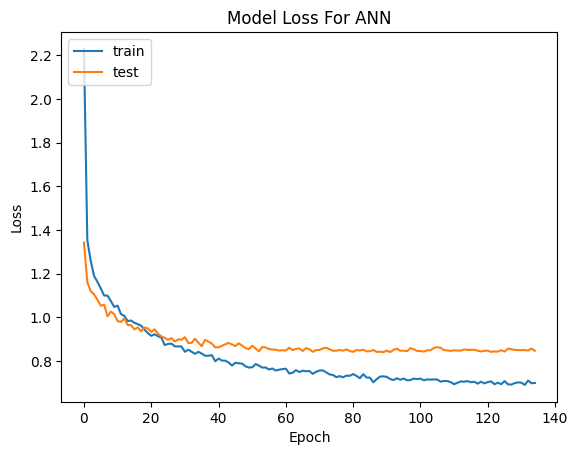

In [ ]:
# Plot the loss
plt.plot(results.history['loss'])
plt.plot(results.history['val_loss'])
plt.title('Model Loss For ANN')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

##Combine the models together to train a combined neural network

In [ ]:
# # Size to reshape images to
# img_size_shape = 224

# # Rescale the pixel data
# image_train_generator = ImageDataGenerator(rescale=1./255)
# image_test_generator = ImageDataGenerator(rescale=1./255)

# # Specify the batch pulls for the train generator
# image_train_generator = image_train_generator.flow_from_dataframe(
#     dataframe=train_image,
#     x_col='image_path',
#     y_col='marketPrice',
#     target_size=(img_size_shape, img_size_shape),
#     batch_size=32,
#     class_mode='raw'
# )

# # Specify the batch pulls for the test generator
# image_test_generator = image_test_generator.flow_from_dataframe(
#     dataframe=val_image,
#     x_col='image_path',
#     y_col='marketPrice',
#     target_size=(img_size_shape, img_size_shape),
#     batch_size=32,
#     class_mode='raw'
# )

In [ ]:
# # Function to combine the image and regular data
# def data_gen(image_gen, tabular_array):
#   while True:
#     imgs, y = next(image_gen)
#     inx = image_gen.index_array
#     tab = tabular_array[inx]
#     yield [imgs, tab], y

In [ ]:


# # Get the combined data
# train_ds = data_gen(image_train_generator, X_train.values)
# val_ds = data_gen(image_test_generator, X_val.values)

In [ ]:
# import cv2
# from tqdm import tqdm

# # Size to reshape images
# img_size_shape = 224

# # Function to load the images
# def load_image(path, target_size=(img_size_shape, img_size_shape)):
#     img = cv2.imread(path)
#     img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
#     img = cv2.resize(img, target_size)
#     img = img / 255.0
#     return img

# # Function to load the image dataset using the load_image function
# def load_image_dataset(paths, target_size=(img_size_shape, img_size_shape)):
#     images = []
#     for p in tqdm(paths, "Loading Images"):
#         images.append(load_image(p, target_size))
#     return np.array(images, dtype="float32")

In [ ]:
# # Load the image dataset
# train_images = load_image_dataset(train_image['image_path'].values)
# val_images = load_image_dataset(val_image['image_path'].values)

In [13]:
image_size_shape = 224

def load_image(path, label):
    img = tf.io.read_file(path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, [image_size_shape, image_size_shape])
    img = img / 255.0
    return img, label

train_image_ds = (
    tf.data.Dataset.from_tensor_slices(
        (train_image['image_path'].values,
         train_image['marketPrice'].values)
    )
    .map(load_image, num_parallel_calls=tf.data.AUTOTUNE)
    .batch(64)
    .prefetch(tf.data.AUTOTUNE)
)

val_image_ds = (
    tf.data.Dataset.from_tensor_slices(
        (val_image['image_path'].values,

         val_image['marketPrice'].values)
    )
    .map(load_image, num_parallel_calls=tf.data.AUTOTUNE)
    .batch(64)
    .prefetch(tf.data.AUTOTUNE)
)

In [14]:
# Convert structured data to tensorflow dataset
structured_train_ds = tf.data.Dataset.from_tensor_slices(X_train.values).batch(64)
structured_val_ds   = tf.data.Dataset.from_tensor_slices(X_val.values).batch(64)
y_train_ds = train_image_ds.map(lambda img, y: y) # pull from image to avoid misalignments
y_val_ds   = val_image_ds.map(lambda img, y: y)

# Pull out the images separately
images_train_ds = train_image_ds.map(lambda img, y: img)
images_val_ds   = val_image_ds.map(lambda img, y: img)


# Zip them up to combine
train_ds = tf.data.Dataset.zip(
    ((images_train_ds, structured_train_ds), y_train_ds)
).prefetch(tf.data.AUTOTUNE)

val_ds = tf.data.Dataset.zip(
    ((images_val_ds, structured_val_ds), y_val_ds)
).prefetch(tf.data.AUTOTUNE)


In [15]:
# Load the models
fine_tuned_image_model = keras.models.load_model('/content/drive/MyDrive/Capstone/best_efficientnet_image_model_v2.keras', compile=False)
fine_tuned_structured_model = keras.models.load_model('/content/drive/MyDrive/Capstone/best_structured_model_v2.keras', compile=False)

# Load the output layer to be combined later
fine_tuned_image_layer = Model(
    inputs=fine_tuned_image_model.input,
    outputs=fine_tuned_image_model.layers[-2].output,
    name="image_submodel"
)

fine_tuned_structured_layer = Model(
    inputs=fine_tuned_structured_model.input,
    outputs=fine_tuned_structured_model.layers[-2].output,
    name="structured_submodel"
)


In [16]:
# Build the model's arcitecture
x = layers.concatenate([fine_tuned_image_layer.output, fine_tuned_structured_layer.output])
x = Dense(64, activation='relu', name='dense_hidden_final')(x)
last_layer = Dense(1, activation='linear')(x)

# Declare inputs and outputs
combined_model = Model(inputs=[fine_tuned_image_layer.input, fine_tuned_structured_layer.input], outputs=last_layer)

# Set learning rate
init_learning_rate = 1e-3

# Compile the model
combined_model.compile(
    optimizer=Adam(learning_rate=init_learning_rate),
    loss='mse',
    metrics=['mse']
)

# Print the final summary
print(combined_model.summary())

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ efficientnetv2-b0   │ (None, 7, 7,      │  5,919,312 │ input_layer_1[0]… │
│ (Functional)        │ 1280)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ structured_input    │ (None, 25)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 1280)      │          0 │ efficientnetv2-b… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 64)        │      1,664 │ structured_input… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_norm_image    │ (None, 1280)      │      5,120 │ global_average_p… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_norm_struct_1 │ (None, 64)        │        256 │ dense_1[0][0]     │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ first_dense_hidden… │ (None, 256)       │    327,936 │ batch_norm_image… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ first_dense_hidden… │ (None, 32)        │      2,080 │ batch_norm_struc… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 256)       │          0 │ first_dense_hidd… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_norm_struct_2 │ (None, 32)        │        128 │ first_dense_hidd… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ second_dense_hidde… │ (None, 128)       │     32,896 │ dropout[0][0]     │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ second_dense_hidde… │ (None, 16)        │        528 │ batch_norm_struc… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 144)       │          0 │ second_dense_hid… │
│ (Concatenate)       │                   │            │ second_dense_hid… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_hidden_final  │ (None, 64)        │      9,280 │ concatenate[0][0] │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 1)         │         65 │ dense_hidden_fin… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 6,299,265 (24.03 MB)

 Trainable params: 6,235,905 (23.79 MB)

 Non-trainable params: 63,360 (247.50 KB)

None


In [17]:
# Create early stopping and best checkpoint saves
stop = EarlyStopping(monitor='val_loss', patience=30, verbose=1, mode='min', restore_best_weights=True)
best = ModelCheckpoint(filepath='/content/drive/MyDrive/Capstone/best_combined_model_checkpoint_v2.keras', monitor='val_loss', verbose=1, save_best_only=True, mode='min', save_weights_only=False)

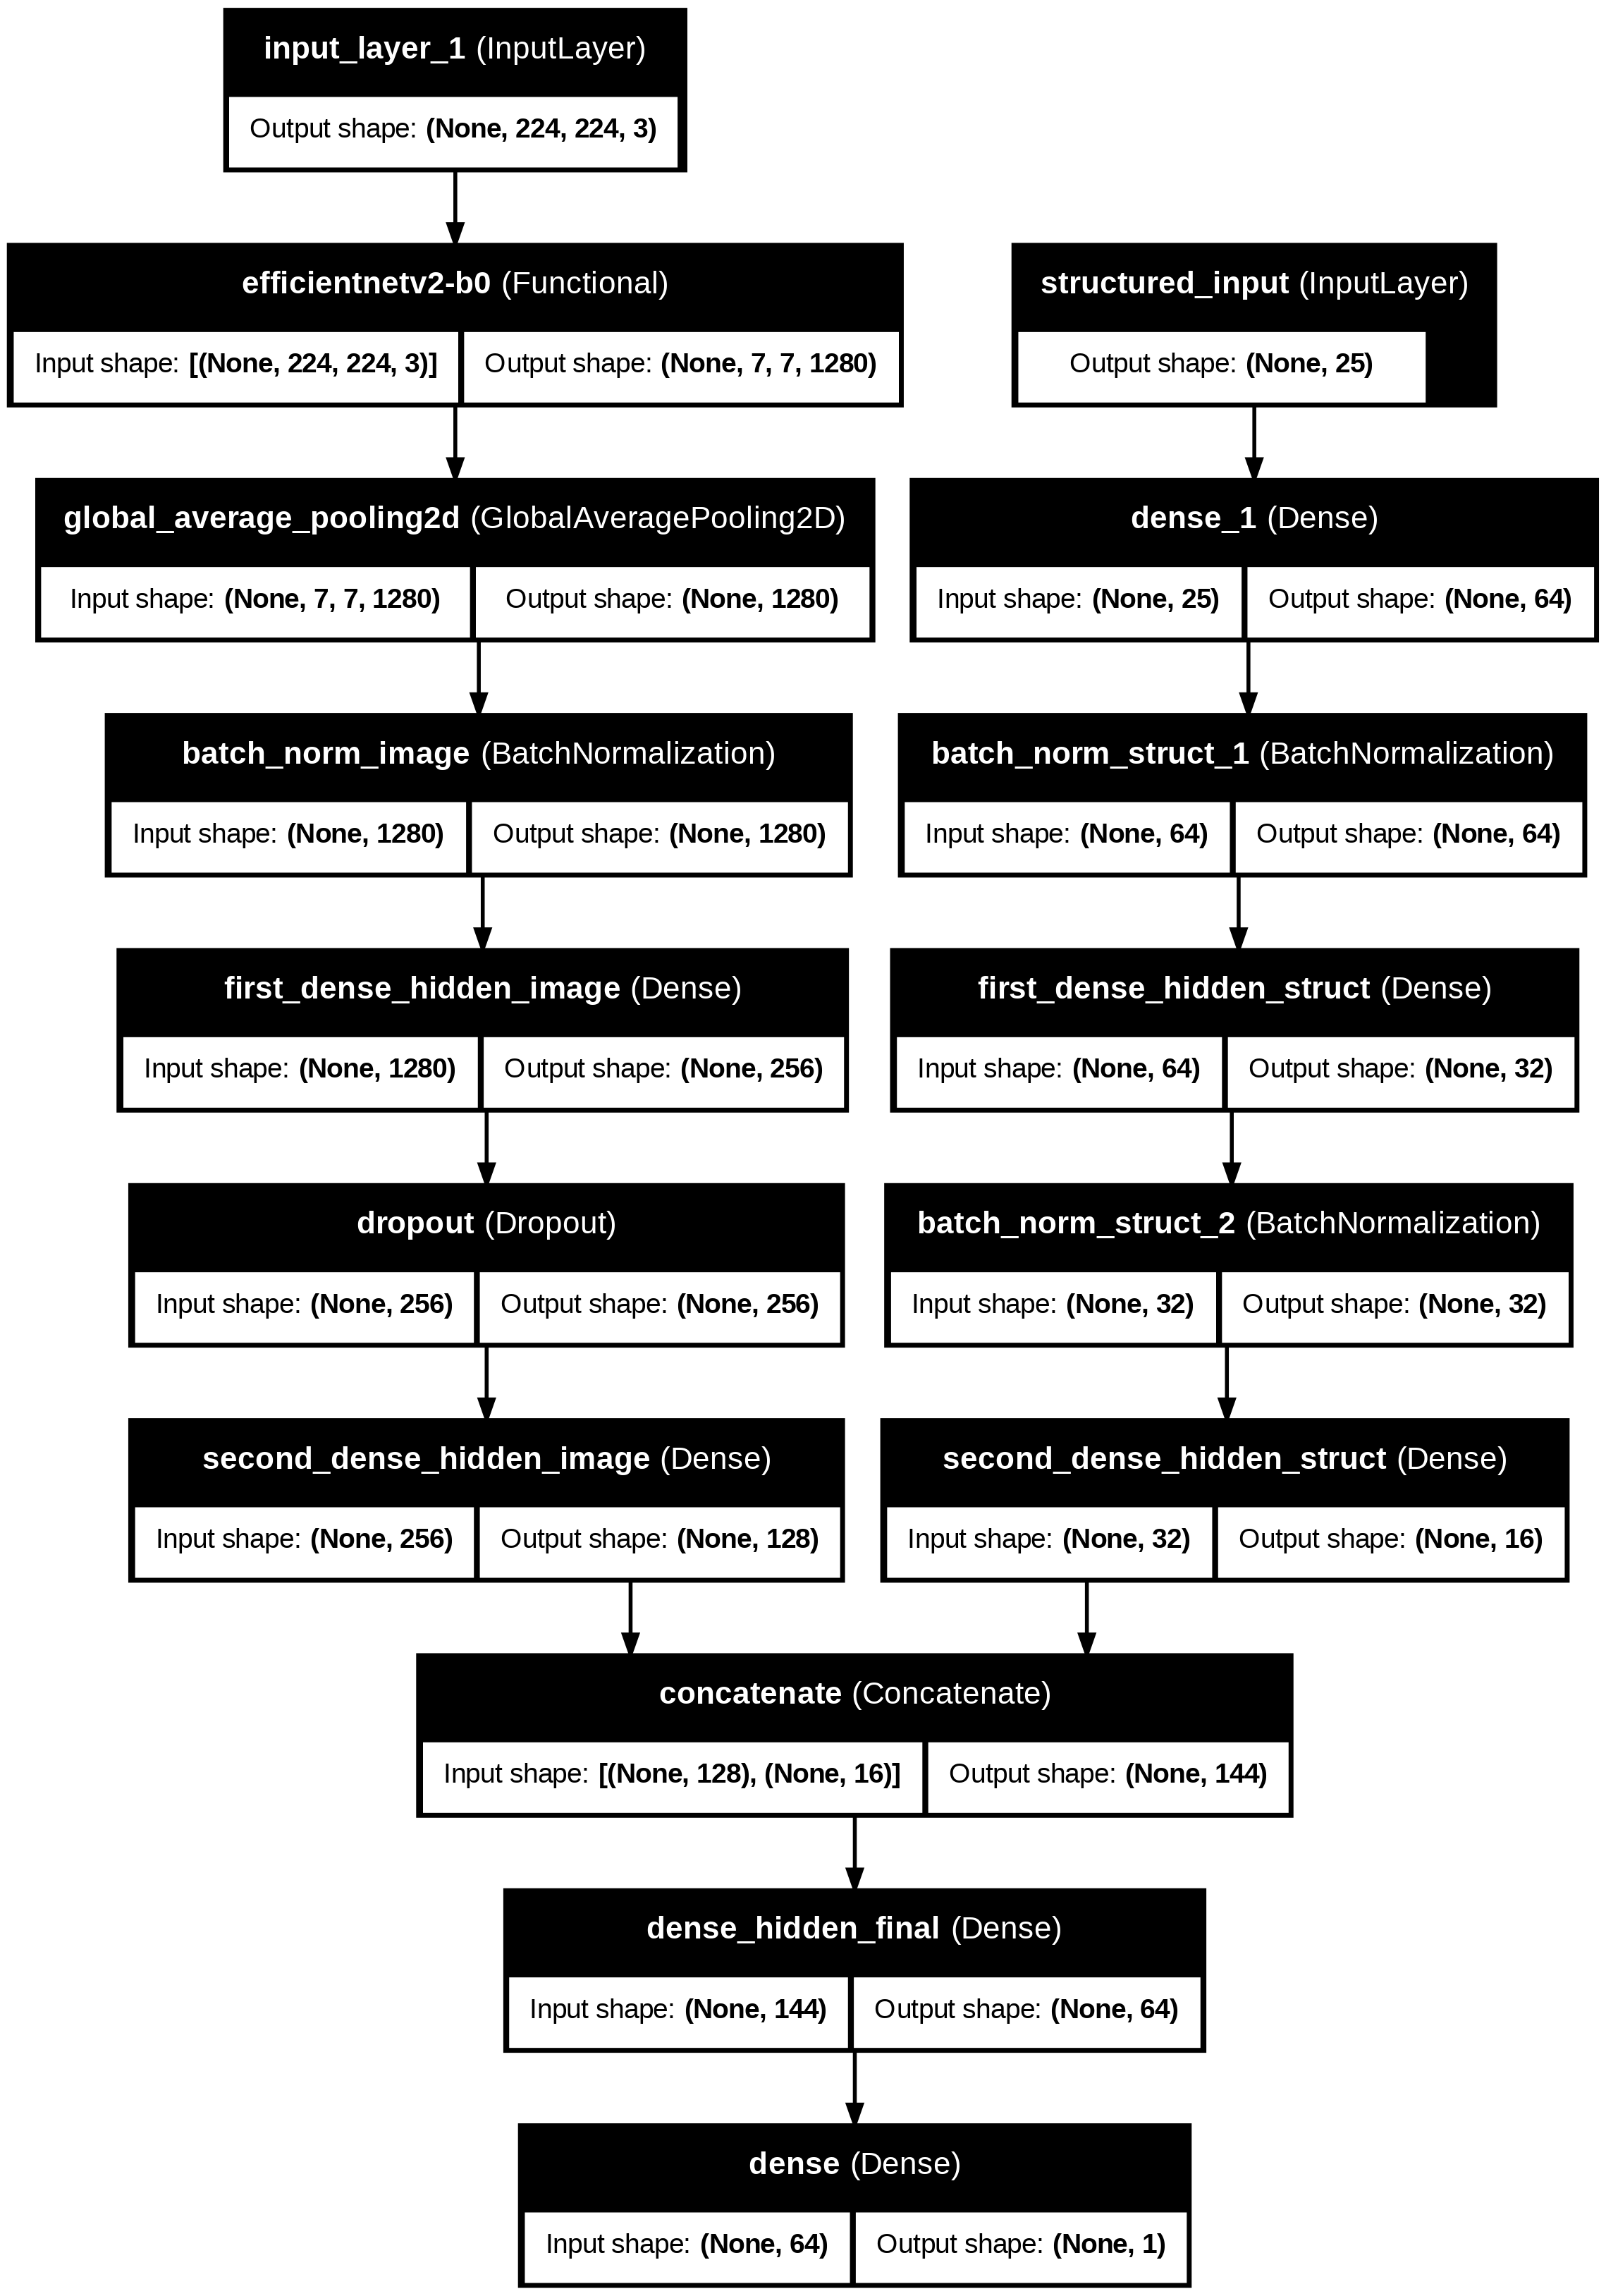

In [18]:
# Show the model
plot_model(combined_model, show_shapes=True, to_file='combined_model.png', show_dtype=False, show_layer_names=True)

In [19]:
# Fit the model
results = combined_model.fit(train_ds,
                             validation_data=val_ds,
                             verbose=1,
                             epochs=500,
                             batch_size=250,
                             callbacks=[stop, best]
                             )

Epoch 1/500


/usr/local/lib/python3.12/dist-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: [['input_layer_1'], ['structured_input']]
Received: inputs=('Tensor(shape=(None, 224, 224, 3))', 'Tensor(shape=(None, 25))')
  warnings.warn(msg)


240/240 ━━━━━━━━━━━━━━━━━━━━ 0s 813ms/step - loss: 1.3592 - mse: 1.3592
Epoch 1: val_loss improved from inf to 0.80969, saving model to /content/drive/MyDrive/Capstone/best_combined_model_checkpoint_v2.keras
240/240 ━━━━━━━━━━━━━━━━━━━━ 359s 1s/step - loss: 1.3578 - mse: 1.3578 - val_loss: 0.8097 - val_mse: 0.8097
Epoch 2/500
240/240 ━━━━━━━━━━━━━━━━━━━━ 0s 516ms/step - loss: 0.7514 - mse: 0.7514
Epoch 2: val_loss did not improve from 0.80969
240/240 ━━━━━━━━━━━━━━━━━━━━ 153s 635ms/step - loss: 0.7513 - mse: 0.7513 - val_loss: 0.9361 - val_mse: 0.9361
Epoch 3/500
240/240 ━━━━━━━━━━━━━━━━━━━━ 0s 486ms/step - loss: 0.6550 - mse: 0.6550
Epoch 3: val_loss did not improve from 0.80969
240/240 ━━━━━━━━━━━━━━━━━━━━ 195s 605ms/step - loss: 0.6549 - mse: 0.6549 - val_loss: 0.9242 - val_mse: 0.9242
Epoch 4/500
240/240 ━━━━━━━━━━━━━━━━━━━━ 0s 502ms/step - loss: 0.6144 - mse: 0.6144
Epoch 4: val_loss did not improve from 0.80969
240/240 ━━━━━━━━━━━━━━━━━━━━ 149s 620ms/step - loss: 0.6143 - mse: 0.

In [20]:
# Save the combined model
combined_model.save('/content/drive/MyDrive/Capstone/best_combined_model_v2.keras')

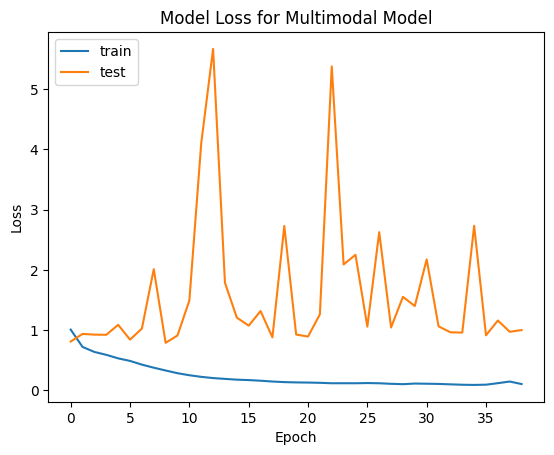

In [21]:
# Plot the loss
plt.plot(results.history['loss'])
plt.plot(results.history['val_loss'])
plt.title('Model Loss for Multimodal Model')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

##Results

In [22]:
# Prepare final testing data
X_test = test_df.drop(columns=['id','name', 'marketPrice'])
y_test = test_df['marketPrice']

# Size to reshape images to
img_size_shape = 224

# Rescale image data
image_test_generator = ImageDataGenerator(rescale=1./255)

# Specify the batch pulls for the test generator
image_test_generator = image_test_generator.flow_from_dataframe(
    dataframe=test_im_df,
    x_col='image_path',
    y_col='marketPrice',
    target_size=(img_size_shape, img_size_shape),
    batch_size=32,
    class_mode='raw'
)

test_image_ds = (
    tf.data.Dataset.from_tensor_slices(
        (test_im_df['image_path'].values,
         test_im_df['marketPrice'].values)
    )
    .map(load_image, num_parallel_calls=tf.data.AUTOTUNE)
    .batch(64)
    .prefetch(tf.data.AUTOTUNE)
)

Found 188 validated image filenames.


In [23]:
# Convert structured data to tensorflow dataset and pull image data to avoid misalignments
structured_test_ds = tf.data.Dataset.from_tensor_slices(X_test.values).batch(64)
y_test_ds = test_image_ds.map(lambda img, y: y)

# Pull out images separately
images_test_ds = test_image_ds.map(lambda img, y: img)

# Zip up and combine
test_ds = tf.data.Dataset.zip(
    ((images_test_ds, structured_test_ds), y_test_ds)
).prefetch(tf.data.AUTOTUNE)

In [24]:
# Load the models
combined_model = keras.models.load_model('/content/drive/MyDrive/Capstone/best_combined_model_v2.keras', compile=False)
fine_tuned_image_model = keras.models.load_model('/content/drive/MyDrive/Capstone/best_efficientnet_image_model_v2.keras', compile=False)
fine_tuned_structured_model = keras.models.load_model('/content/drive/MyDrive/Capstone/best_structured_model_v2.keras', compile=False)

In [25]:
# Perform predictions
y_pred_image = fine_tuned_image_model.predict(image_test_generator)
y_pred_structured = fine_tuned_structured_model.predict(X_test)
y_pred_combined = combined_model.predict(test_ds)

# Inverse the log transform on all values
y_pred_image = np.exp(y_pred_image)
y_pred_structured = np.exp(y_pred_structured)
y_pred_combined = np.exp(y_pred_combined)
y_test = np.exp(y_test)

# Create comparison dataframe
y_pred_compare = pd.DataFrame(y_test)
y_pred_compare.columns = ['Y_TRUE']
y_pred_compare['Y_PRED_IMAGE'] = y_pred_image
y_pred_compare['Y_PRED_STRUCTURED'] = y_pred_structured
y_pred_compare['Y_PRED_COMBINED'] = y_pred_combined
y_pred_compare['MEAN'] = np.mean(y_train.ravel()) # Check if models perform better than just predicting the mean

print("Mean price: ", np.mean(y_train.ravel()))


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


6/6 ━━━━━━━━━━━━━━━━━━━━ 25s 3s/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 98ms/step


/usr/local/lib/python3.12/dist-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: [['input_layer_1'], ['structured_input']]
Received: inputs=('Tensor(shape=(64, 224, 224, 3))', 'Tensor(shape=(64, 25))')
  warnings.warn(msg)


2/3 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step

/usr/local/lib/python3.12/dist-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: [['input_layer_1'], ['structured_input']]
Received: inputs=('Tensor(shape=(None, 224, 224, 3))', 'Tensor(shape=(None, 25))')
  warnings.warn(msg)


3/3 ━━━━━━━━━━━━━━━━━━━━ 22s 7s/step
Mean price:  0.021131031373223974


/tmp/ipython-input-1170670598.py:18: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  y_pred_compare['MEAN'] = np.mean(y_train.ravel()) # Check if models perform better than just predicting the mean
/tmp/ipython-input-1170670598.py:20: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  print("Mean price: ", np.mean(y_train.ravel()))


In [26]:
y_pred_compare.head()

,Y_TRUE,Y_PRED_IMAGE,Y_PRED_STRUCTURED,Y_PRED_COMBINED,MEAN
19192,0.09,0.164399,0.079288,0.070722,0.021131
19193,0.16,0.129686,0.075416,0.074981,0.021131
19194,1.00,0.073330,0.966001,2.676584,0.021131
19195,0.04,0.086434,0.073560,0.079206,0.021131
19196,0.05,0.090836,0.064501,0.077667,0.021131


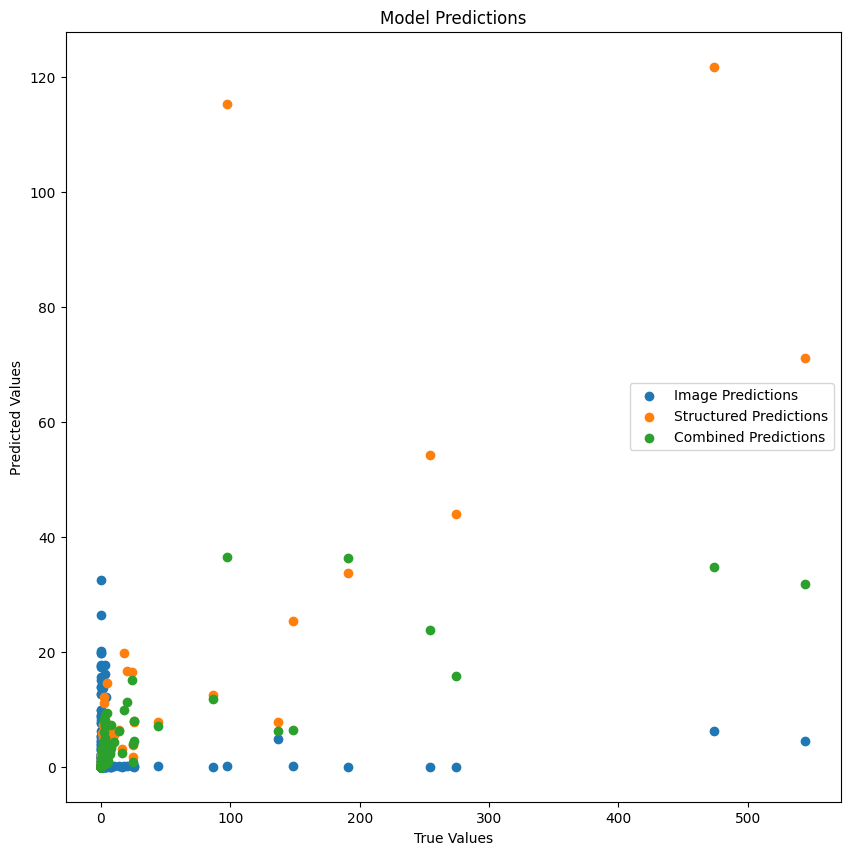

In [27]:
plt.figure(figsize=(10, 10))
plt.scatter(y_pred_compare['Y_TRUE'], y_pred_compare['Y_PRED_IMAGE'], label='Image Predictions')
plt.scatter(y_pred_compare['Y_TRUE'], y_pred_compare['Y_PRED_STRUCTURED'], label='Structured Predictions')
plt.scatter(y_pred_compare['Y_TRUE'], y_pred_compare['Y_PRED_COMBINED'], label='Combined Predictions')
plt.title('Model Predictions')
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.legend()
plt.show()

In [28]:
def plot_residuals(y_true, y_pred, title):
    residuals = y_true - y_pred
    plt.scatter(y_true, residuals)
    plt.axhline(y=0, color='r', linestyle='--')
    plt.title(title)
    plt.xlabel('True Values')
    plt.ylabel('Residuals')
    plt.show()

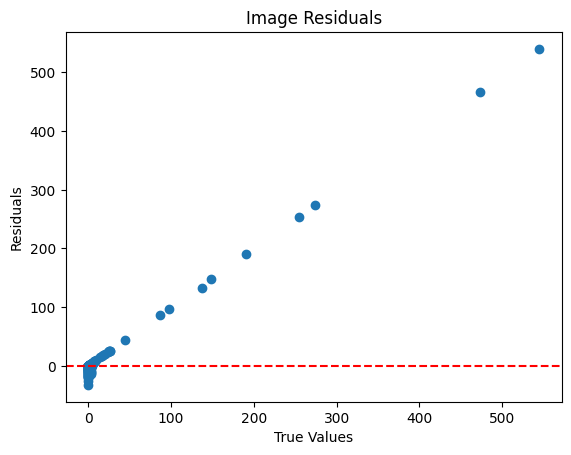

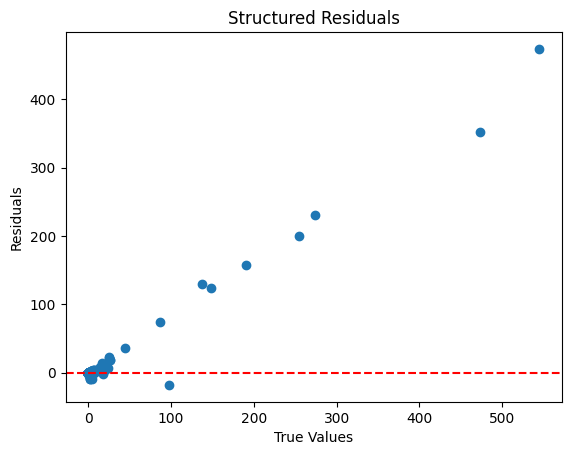

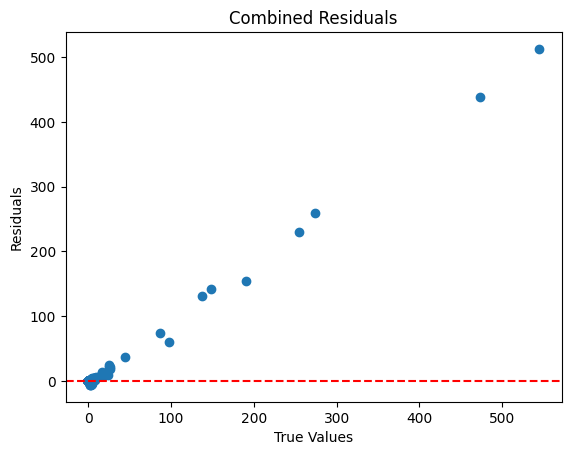

In [29]:
plot_residuals(y_pred_compare['Y_TRUE'], y_pred_compare['Y_PRED_IMAGE'], 'Image Residuals')
plot_residuals(y_pred_compare['Y_TRUE'], y_pred_compare['Y_PRED_STRUCTURED'], 'Structured Residuals')
plot_residuals(y_pred_compare['Y_TRUE'], y_pred_compare['Y_PRED_COMBINED'], 'Combined Residuals')

In [30]:

# Create a new table for different statistics
statistics = pd.DataFrame({
    'MODEL': ['IMAGE', 'STRUCTURED', 'COMBINED', 'MEAN'],
    'R2' : [
        metrics.r2_score(y_pred_compare['Y_TRUE'], y_pred_compare['Y_PRED_IMAGE']),
        metrics.r2_score(y_pred_compare['Y_TRUE'], y_pred_compare['Y_PRED_STRUCTURED']),
        metrics.r2_score(y_pred_compare['Y_TRUE'], y_pred_compare['Y_PRED_COMBINED']),
        metrics.r2_score(y_pred_compare['Y_TRUE'], y_pred_compare['MEAN'])
    ],
    'RMSE' : [
        np.sqrt(metrics.mean_squared_error(y_pred_compare['Y_TRUE'], y_pred_compare['Y_PRED_IMAGE'])),
        np.sqrt(metrics.mean_squared_error(y_pred_compare['Y_TRUE'], y_pred_compare['Y_PRED_STRUCTURED'])),
        np.sqrt(metrics.mean_squared_error(y_pred_compare['Y_TRUE'], y_pred_compare['Y_PRED_COMBINED'])),
        np.sqrt(metrics.mean_squared_error(y_pred_compare['Y_TRUE'], y_pred_compare['MEAN']))
    ],
    'MAE' : [
        metrics.mean_absolute_error(y_pred_compare['Y_TRUE'], y_pred_compare['Y_PRED_IMAGE']),
        metrics.mean_absolute_error(y_pred_compare['Y_TRUE'], y_pred_compare['Y_PRED_STRUCTURED']),
        metrics.mean_absolute_error(y_pred_compare['Y_TRUE'], y_pred_compare['Y_PRED_COMBINED']),
        metrics.mean_absolute_error(y_pred_compare['Y_TRUE'], y_pred_compare['MEAN'])
    ],
    'MAPE' : [
        metrics.mean_absolute_percentage_error(y_pred_compare['Y_TRUE'], y_pred_compare['Y_PRED_IMAGE']),
        metrics.mean_absolute_percentage_error(y_pred_compare['Y_TRUE'], y_pred_compare['Y_PRED_STRUCTURED']),
        metrics.mean_absolute_percentage_error(y_pred_compare['Y_TRUE'], y_pred_compare['Y_PRED_COMBINED']),
        metrics.mean_absolute_percentage_error(y_pred_compare['Y_TRUE'], y_pred_compare['MEAN'])
    ],
    'MedAE' : [
        metrics.median_absolute_error(y_pred_compare['Y_TRUE'], y_pred_compare['Y_PRED_IMAGE']),
        metrics.median_absolute_error(y_pred_compare['Y_TRUE'], y_pred_compare['Y_PRED_STRUCTURED']),
        metrics.median_absolute_error(y_pred_compare['Y_TRUE'], y_pred_compare['Y_PRED_COMBINED']),
        metrics.median_absolute_error(y_pred_compare['Y_TRUE'], y_pred_compare['MEAN'])
    ]
})

In [31]:
# Display the statstics table
display(statistics)

,MODEL,R2,RMSE,MAE,MAPE,MedAE
0,IMAGE,-0.042115,63.438132,16.089411,54.705116,1.515020
1,STRUCTURED,0.300836,51.961573,10.845115,0.917893,0.045609
2,COMBINED,0.104170,58.817331,12.184609,0.910455,0.052331
3,MEAN,-0.049886,63.674244,13.879923,0.678060,0.058869


In [32]:
# Save dataframes
statistics.to_csv('/content/drive/MyDrive/Capstone/model_stats_v2.csv', index=False)
y_pred_compare.to_csv('/content/drive/MyDrive/Capstone/model_test_predictions_v2.csv', index=False)